# Case 21.1 Charles Book Club

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [40]:
%matplotlib inline
from pathlib import Path
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt

from dmba import gainsChart, liftChart

## Data preparation

In [2]:
# Load the data
df = pd.read_csv('CharlesBookClub.csv')

In [3]:
# Prepare data for model building
df.head()

,Seq#,ID#,Gender,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,...,ItalCook,ItalAtlas,ItalArt,Florence,Related Purchase,Mcode,Rcode,Fcode,Yes_Florence,No_Florence
0,1,25,1,297,14,2,22,0,1,1,...,0,0,0,0,0,5,4,2,0,1
1,2,29,0,128,8,2,10,0,0,0,...,0,0,0,0,0,4,3,2,0,1
2,3,46,1,138,22,7,56,2,1,2,...,1,0,0,0,2,4,4,3,0,1
3,4,47,1,228,2,1,2,0,0,0,...,0,0,0,0,0,5,1,1,0,1
4,5,51,1,257,10,1,10,0,0,0,...,0,0,0,0,0,5,3,1,0,1


## 1. Partition the data into training (60\%) and validation (40\%). Use seed = 1.

In [4]:
# in this case, we split the full dataframe including all columns
outcome = 'Yes_Florence'
train_df, valid_df, train_y, valid_y = train_test_split(df, df[outcome], test_size=0.4, random_state=1)

train_df.shape, valid_df.shape

((2400, 24), (1600, 24))

### 1.1 What is the response rate for the training data customers taken as a whole? What is the response rate for each of the $4 \times 5 \times 3 = 60$ combinations of RFM categories? Which combinations have response rates in the training data that are above the overall response in the training data?

In [5]:
average_response_rate = train_df[outcome].mean()
print('average response rate for training data', average_response_rate)
print('average response rate for validation data', valid_df[outcome].mean())

average response rate for training data 0.08833333333333333
average response rate for validation data 0.07875


In [6]:
RFMcategories = ['Rcode', 'Fcode', 'Mcode']
average_by_combination = train_df.groupby(RFMcategories)['Yes_Florence'].mean()
average_by_combination

Rcode  Fcode  Mcode
1      1      1        0.000000
              2        0.000000
              3        0.000000
              4        0.200000
              5        0.173913
       2      2        0.666667
              3        0.000000
              4        0.050000
              5        0.080000
       3      3        0.333333
              4        0.062500
              5        0.153846
2      1      1        0.400000
              2        0.333333
              3        0.150000
              4        0.000000
              5        0.172414
       2      2        0.142857
              3        0.166667
              4        0.161290
              5        0.043478
       3      3        0.333333
              4        0.200000
              5        0.177778
3      1      1        0.100000
              2        0.090909
              3        0.027778
              4        0.074074
              5        0.035088
       2      2        0.043478
              3     

In [7]:
combinations_above_average = average_by_combination[average_by_combination > average_response_rate]
combinations_above_average

Rcode  Fcode  Mcode
1      1      4        0.200000
              5        0.173913
       2      2        0.666667
       3      3        0.333333
              5        0.153846
2      1      1        0.400000
              2        0.333333
              3        0.150000
              5        0.172414
       2      2        0.142857
              3        0.166667
              4        0.161290
       3      3        0.333333
              4        0.200000
              5        0.177778
3      1      1        0.100000
              2        0.090909
       3      5        0.136585
4      1      3        0.140845
              4        0.111111
       3      3        0.105263
              4        0.088496
Name: Yes_Florence, dtype: float64

The index of the data series is a multi-index.

In [ ]:
combinations_above_average.index

MultiIndex([(1, 1, 4),
            (1, 1, 5),
            (1, 2, 2),
            (1, 3, 3),
            (1, 3, 5),
            (2, 1, 1),
            (2, 1, 2),
            (2, 1, 3),
            (2, 1, 5),
            (2, 2, 2),
            (2, 2, 3),
            (2, 2, 4),
            (2, 3, 3),
            (2, 3, 4),
            (2, 3, 5),
            (3, 1, 1),
            (3, 1, 2),
            (3, 3, 5),
            (4, 1, 3),
            (4, 1, 4),
            (4, 3, 3),
            (4, 3, 4)],
           names=['Rcode', 'Fcode', 'Mcode'])

In [9]:
sum(train_df.groupby(RFMcategories)['Yes_Florence'].sum()[combinations_above_average.index]) / \
sum(train_df.groupby(RFMcategories)['Yes_Florence'].count()[combinations_above_average.index])

0.14523281596452328

### 1.2 Suppose that we decide to send promotional mail only to the "above-average" RFM combinations identified in part 1. Compute the response rate in the validation data using these combinations.

In [10]:
# group validation data by RFM combinations
grouped = valid_df.groupby(RFMcategories)

# count the number of responses for each group
rfm_counts = grouped['Yes_Florence'].count()
rfm_responses = grouped['Yes_Florence'].sum()

In [22]:
# and subset to combinations that were above average for the training set
above_average_rfm_counts = [rfm_counts[x] for x in combinations_above_average.index if x in rfm_counts.index]
above_average_rfm_responses = [rfm_responses[x] for x in combinations_above_average.index if x in rfm_responses.index]

In [23]:
# Total number of responses in validation set when sending to above average combinations
print('Number of customers in above average combinations (validation)', sum(above_average_rfm_counts))
print('Responses from customers in above average combinations (validation)', sum(above_average_rfm_responses))

print('response rate', sum(above_average_rfm_responses) / sum(above_average_rfm_counts))

Number of customers in above average combinations (validation) 606
Responses from customers in above average combinations (validation) 53
response rate 0.08745874587458746


We can see that for segments 1 and 2, we get an above average response rate (grey line).

Note: the outcome of this analysis greatly depends on the split of the dataset into training and validation sets. Vary the `random_state` and observe the effect it has on the response rates for the various segments

## 2. The $k$-NN technique can be used to create segments based on product proximity to similar products of the products offered as well as the propensity to purchase (as measured by the RFM variables).  For "The Art History of Florence", a possible segmentation by product proximity could be created using the following variables:

- R: recency - months since last purchase
- F: frequency - total number of past purchases
- M: monetary - total money (in dollars) spent on books
- FirstPurch: months since first purchase
- RelatedPurch: total number of past purchases of related books (i.e., sum of purchases from the art and geography categories and of titles _Secrets of Italian Cooking_, _Historical Atlas of Italy_,  and _Italian Art_)

### 2.1 Use the $k$-NN approach to classify cases with $k=1, 2, ..., 11$, using Florence as the outcome variable. Based on the validation set, find the best $k$. Remember to normalize all five variables. With the validation data, create a gains chart for the best $k$ model, and report the expected gains for the same number of customers that we mailed to in part 2

,k,accuracy
0,1,0.846875
1,2,0.912500
2,3,0.895000
3,4,0.917500
4,5,0.913750
5,6,0.919375
6,7,0.916875
7,8,0.918750
8,9,0.916875
9,10,0.920000


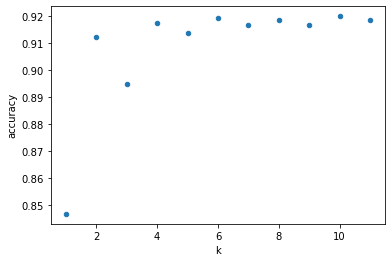

In [24]:
outcome = 'Yes_Florence'
predictors = ['M', 'R', 'F', 'FirstPurch', 'Related Purchase']

# train standard scaler using the training set
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])

train_norm = scaler.transform(train_df[predictors])
valid_norm = scaler.transform(valid_df[predictors])

results = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_norm, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_norm))
    })
results = pd.DataFrame(results)
results.plot.scatter(x='k', y='accuracy')
results

Based on this result, we select a $k$ value of 6.

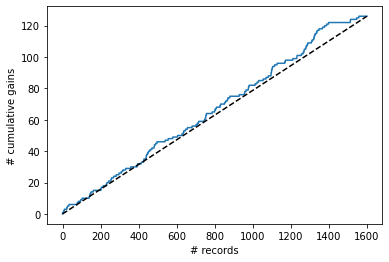

In [25]:
knn = KNeighborsClassifier(n_neighbors=6).fit(train_norm, train_y)

gains_df = pd.DataFrame({
    'actual': valid_y,
    'prob': knn.predict_proba(valid_norm)[:, 1]
})

gains_df = gains_df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

gainsChart(gains_df.actual)
plt.show()

In [27]:
grouped = valid_df.groupby(RFMcategories)['Yes_Florence']
customers_by_rfm = grouped.count()
response_by_rfm = grouped.sum()

# Create the segments 
segment_1 = average_by_combination[2 * average_response_rate < average_by_combination]
segment_2 = average_by_combination[(average_response_rate < average_by_combination) & (average_by_combination <= 2 * average_response_rate)]
segment_3 = average_by_combination[average_by_combination <= average_response_rate]

# Calculate number of customers, responses, and rate for each segment
customers_1 = sum([customers_by_rfm[x] for x in segment_1.index if x in customers_by_rfm.index])
response_1 = sum([response_by_rfm[x] for x in segment_1.index if x in response_by_rfm.index])
rate_1 = response_1 / customers_1
print(f'Segment 1: {customers_1} customers, {response_1} responses, {rate_1} response rate')

customers_2 = sum([customers_by_rfm[x] for x in segment_2.index if x in customers_by_rfm.index])
response_2 = sum([response_by_rfm[x] for x in segment_2.index if x in response_by_rfm.index])
rate_2 = response_2 / customers_2
print(f'Segment 2: {customers_2:.0f} customers, {response_2:.0f} responses, {rate_2:.3f} response rate')

customers_3 = sum([customers_by_rfm[x] for x in segment_3.index if x in customers_by_rfm.index])
response_3 = sum([response_by_rfm[x] for x in segment_3.index if x in response_by_rfm.index])
rate_3 = response_3 / customers_3
print(f'Segment 3: {customers_3:.0f} customers, {response_3:.0f} responses, {rate_3:.3f} response rate')

Segment 1: 106 customers, 10 responses, 0.09433962264150944 response rate
Segment 2: 500 customers, 43 responses, 0.086 response rate
Segment 3: 990 customers, 72 responses, 0.073 response rate


In [28]:
print('Expected response rates for sending to same number of customers as in step 2')
for customers in (customers_1, customers_2, customers_3):
    expected = gains_df.loc[0:customers,]["actual"].sum()
    ratio = expected / customers
    print(f'  {customers:.0f} customers: expect {expected} responses ({ratio:.3f} response rate)')

Expected response rates for sending to same number of customers as in step 2
  106 customers: expect 10 responses (0.094 response rate)
  500 customers: expect 46 responses (0.092 response rate)
  990 customers: expect 82 responses (0.083 response rate)


With the unweighted $k$-NN classifier, the probabilities can take only up to $k+1$ unique values. The gains chart therefore depends greatly on the order of the actual values for the same probability.

In [29]:
# unique probability values and their number of occurrence
gains_df['prob'].value_counts()

0.000000    990
0.166667    415
0.333333    150
0.500000     40
0.666667      3
0.833333      2
Name: prob, dtype: int64

It is in this case therefore better to calculate the gains for these discrete probability values and assume linear behavior of the gains chart between these points (random sampling)

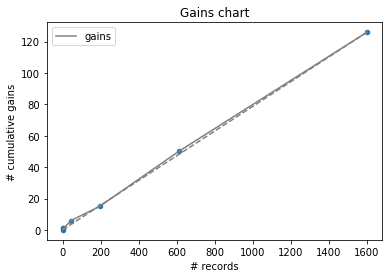

In [30]:
probability_cutoff = [1] + sorted(gains_df['prob'].unique(), reverse=True)

cumulative_count = []
cumulative_gains = []
for cutoff in probability_cutoff:
    subset = gains_df['actual'][gains_df['prob'] >= cutoff]
    cumulative_count.append(subset.count())
    cumulative_gains.append(subset.sum())
discrete_gains = pd.DataFrame({
    'prob': probability_cutoff,
    'count': cumulative_count,
    'gains': cumulative_gains,
})
ax = discrete_gains.plot(x='count', y='gains', color='grey')
discrete_gains.plot.scatter(x='count', y='gains', ax=ax)
ax.plot((0, valid_df[outcome].count()), (0, valid_df[outcome].sum()), color='grey', linestyle='--')
ax.set_title('Gains chart')
ax.set_xlabel('# records')
ax.set_ylabel('# cumulative gains')
plt.show()

This gains chart gives a much more realistic picture of the model behavior.

### 2.2 The $k$-NN prediction algorithm gives a numerical value, which is a weighted average of the values of the Florence variable for the $k$-NN with weights that are inversely proportional to distance. 
Using the best $k$ that you calculated above with $k$-NN classification, now run a model with $k$-NN prediction and compute a gains chart for the validation data. Use all 5 predictors and normalized data. What is the range within which a prediction will fall?  How does this result compare to the output you get with the $k$-NN classification?

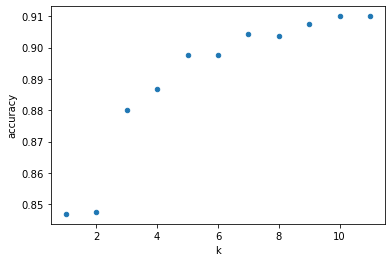

In [32]:
results = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(train_norm, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_norm))
    })
results = pd.DataFrame(results)
results.plot.scatter(x='k', y='accuracy')
plt.show()

### Gains Chart

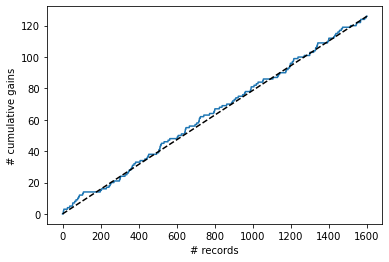

In [33]:
# select k=10
knn = KNeighborsClassifier(n_neighbors=10, weights='distance').fit(train_norm, train_y)

gains_df = pd.DataFrame({
    'actual': valid_y,
    'prob': knn.predict_proba(valid_norm)[:, 1]
})

gains_df = gains_df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

gainsChart(gains_df.actual)
plt.show()

### Decile LiftChart

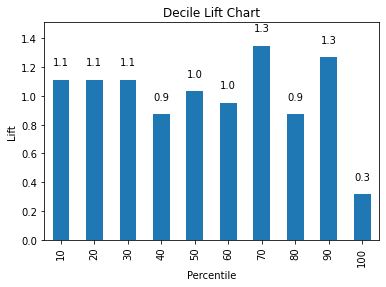

In [41]:
knn = KNeighborsClassifier(n_neighbors=6).fit(train_norm, train_y)

lift_df = pd.DataFrame({
    'actual': valid_y,
    'prob': knn.predict_proba(valid_norm)[:, 1]
})

lift_df = lift_df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

liftChart(lift_df.actual)
plt.show()

In [42]:
print('Expected response rates for sending to same number of customers as in step 2')
for customers in (customers_1, customers_2, customers_3):
    expected = gains_df.loc[0:customers,]["actual"].sum()
    ratio = expected / customers
    print(f'  {customers:.0f} customers: expect {expected} responses ({ratio:.3f} response rate)')

Expected response rates for sending to same number of customers as in step 2
  106 customers: expect 13 responses (0.123 response rate)
  500 customers: expect 39 responses (0.078 response rate)
  990 customers: expect 80 responses (0.081 response rate)


With the distance weighting, we get more variation in the predicted probabilities. However, it should be noted that for a large majority of customers, we predict a probability of 0. This means that in theory we should construct the gains chart similarly to what we have done for the unweighted $k$-NN model. This would however only replace the fluctuating gains line above about `# records` 850 with a straight line.

In [43]:
# Number of unique probability values 
print(gains_df['prob'].nunique())

# Distribution of discrete values
gains_df['prob'].value_counts()

835


0.000000    746
1.000000      5
0.102809      3
0.110845      2
0.024469      2
           ... 
0.178777      1
0.178193      1
0.177523      1
0.176976      1
0.112135      1
Name: prob, Length: 835, dtype: int64

The density plot shows the distribution of the probabilities more clearly.

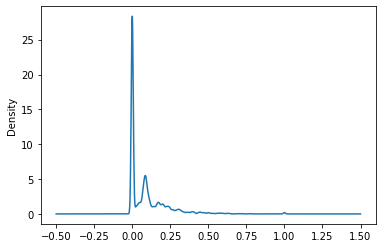

In [44]:
gains_df['prob'].plot.density(bw_method=0.05)
plt.show()

## 3.  The logistic regression model offers a powerful method for modeling response because it  yields well-defined purchase probabilities. The model is especially attractive in consumer-choice settings because it can be derived from the random utility theory of consumer behavior.

Use the training set data of 1800 records to construct three logistic regression models with Florence as the outcome variable and each of the following sets of predictors:

- The full set of 16 predictors in the dataset
- A subset of predictors that you judge to be the best
- Only the $R$, $F$, and $M$ variables

In [45]:
predictors1 = ['Gender', 'M', 'R', 'F', 'FirstPurch', 
               'ChildBks', 'YouthBks', 'CookBks', 'DoItYBks', 'RefBks', 'ArtBks', 'GeogBks',
               'ItalCook', 'ItalAtlas', 'ItalArt', 'Related Purchase']
predictors2 = ['M', 'R', 'F', 'FirstPurch', 
               'CookBks', 'ArtBks', 'GeogBks', 'ItalCook', 'ItalAtlas', 'ItalArt', 
               'Related Purchase']
predictors3 = ['M', 'R', 'F']

logit_reg_1 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_1.fit(train_df[predictors1], train_y)

logit_reg_2 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_2.fit(train_df[predictors2], train_y)

logit_reg_3 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_3.fit(train_df[predictors3], train_y)

LogisticRegression(C=1e+42, solver='liblinear')

### 3.1 If the cutoff criterion for a campaign is a 30\% likelihood of a purchase, find the customers in the validation data that would be targeted and count the number of buyers in this set.

In [50]:
result_1 = pd.DataFrame({
    'actual': valid_y,
    'prob': logit_reg_1.predict_proba(valid_df[predictors1])[:, 1]
})
result_1 = result_1.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

result_2 = pd.DataFrame({
    'actual': valid_y,
    'prob': logit_reg_2.predict_proba(valid_df[predictors2])[:, 1]
})
result_2 = result_2.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

result_3 = pd.DataFrame({
    'actual': valid_y,
    'prob': logit_reg_3.predict_proba(valid_df[predictors3])[:, 1]
})
result_3 = result_3.sort_values(by=['prob'], ascending=False).reset_index(drop=True)


target_1 = result_1[result_1.prob >= 0.3]
target_2 = result_2[result_2.prob >= 0.3]
target_3 = result_3[result_3.prob >= 0.3]

for model, target in enumerate([target_1, target_2, target_3], 1):
    count = target["actual"].count()
    expected = target["actual"].sum()
    print(f'Model {model}')
    if count > 0:
        ratio = expected / count
        print(f'  {count} customers: expect {expected} responses ({ratio:.3f} response rate)')
    else:
        print(f'  {count} customers: expect {expected} responses')


Model 1
  35 customers: expect 10 responses (0.286 response rate)
Model 2
  32 customers: expect 9 responses (0.281 response rate)
Model 3
  0 customers: expect 0 responses


### 3.2 Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team.